# Logistic Regression - Holdouts

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

## Original Dataset

In [1]:
# Load Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import ds_functions as ds

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/qsar_oral_toxicity.csv', sep=';', header=None)
y: np.ndarray = data.iloc[:,-1:].values
y: np.ndarray = np.array([x[0] for x in y])
X: np.ndarray = data.iloc[:,:-1]
labels = pd.unique(y)

In [3]:
def holdout_model(X, y, penalty, C, max_iters, n_holdouts=1000):
    # Compute the Average metrics and CNFMTX for a set of hyper-parameters

    acc = [0, 0]
    recall = [0, 0]
    specificity = [0, 0]
    precision = [0, 0]
    matrices = np.zeros((2, 2, n_holdouts))

    for h in range(n_holdouts):
        trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

        logreg = LogisticRegression(penalty=penalty, C=C, max_iter=max_iters)
        logreg.fit(trnX, trnY)

        prd_trn = logreg.predict(trnX)
        prd_tst = logreg.predict(tstX)

        cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
        matrices[:,:,h] = cnf_mtx_tst
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
        acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)

        recall[0] += tp_trn / (tp_trn + fn_trn)
        recall[1] += tp_tst / (tp_tst + fn_tst)

        specificity[0] += tn_trn / (tn_trn + fp_trn)
        specificity[1] += tn_tst / (tn_tst + fp_tst)

        precision[0] += tp_trn / (tp_trn + fp_trn)
        precision[1] += tp_tst / (tp_tst + fp_tst)


    acc = np.divide(acc, n_holdouts)
    recall = np.divide(recall, n_holdouts)
    specificity = np.divide(specificity, n_holdouts)
    precision = np.divide(precision, n_holdouts)
    cnf_mtx = np.mean(matrices, axis=2).astype('int64')

    evaluation = {'Accuracy': acc,
                  'Recall': recall,
                  'Specificity': specificity,
                  'Precision': precision}
    
    return evaluation, cnf_mtx

In [4]:
def log_reg_analysis(X, y, n_holdouts=1000):
    
    max_acc = -1

    penalty = ['l2', 'none']
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    max_iters = [10, 25, 50, 100, 200]
        
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
    
    for p in penalty:
        
        values = {}
        
        for c in C:
            
            acc_values = []
            
            for max_i in max_iters:
                
                evaluation, cnf_mtx = holdout_model(X, y, p, c, max_i, n_holdouts)
                
                acc_values.append(evaluation['Accuracy'][1])
                
                if evaluation['Accuracy'][1] > max_acc:
                                       
                    best_model = (p, c, max_i)
                    best_metrics = evaluation, cnf_mtx
                    max_acc = evaluation['Accuracy'][1]
                    
            values[c] = acc_values
                        
        ds.multiple_line_chart(max_iters, values, ax=axs[0, penalty.index(p)], title='Logistic Regression with %s penalty' % p,
                               xlabel='Maximum Iterations', ylabel='Accuracy', percentage=True, ymin=0.6, ymax=1)

                    
    return best_model, evaluation, cnf_mtx

In [5]:
def pretty_metrics(evaluation):
        
    print('\tModel Statistics\n===============================')

    for k in evaluation.keys():
        line_new = '%12s  %.2f  %.2f' % (k, evaluation[k][0], evaluation[k][1])
        
        print(line_new)
                

<Figure size 600x450 with 0 Axes>

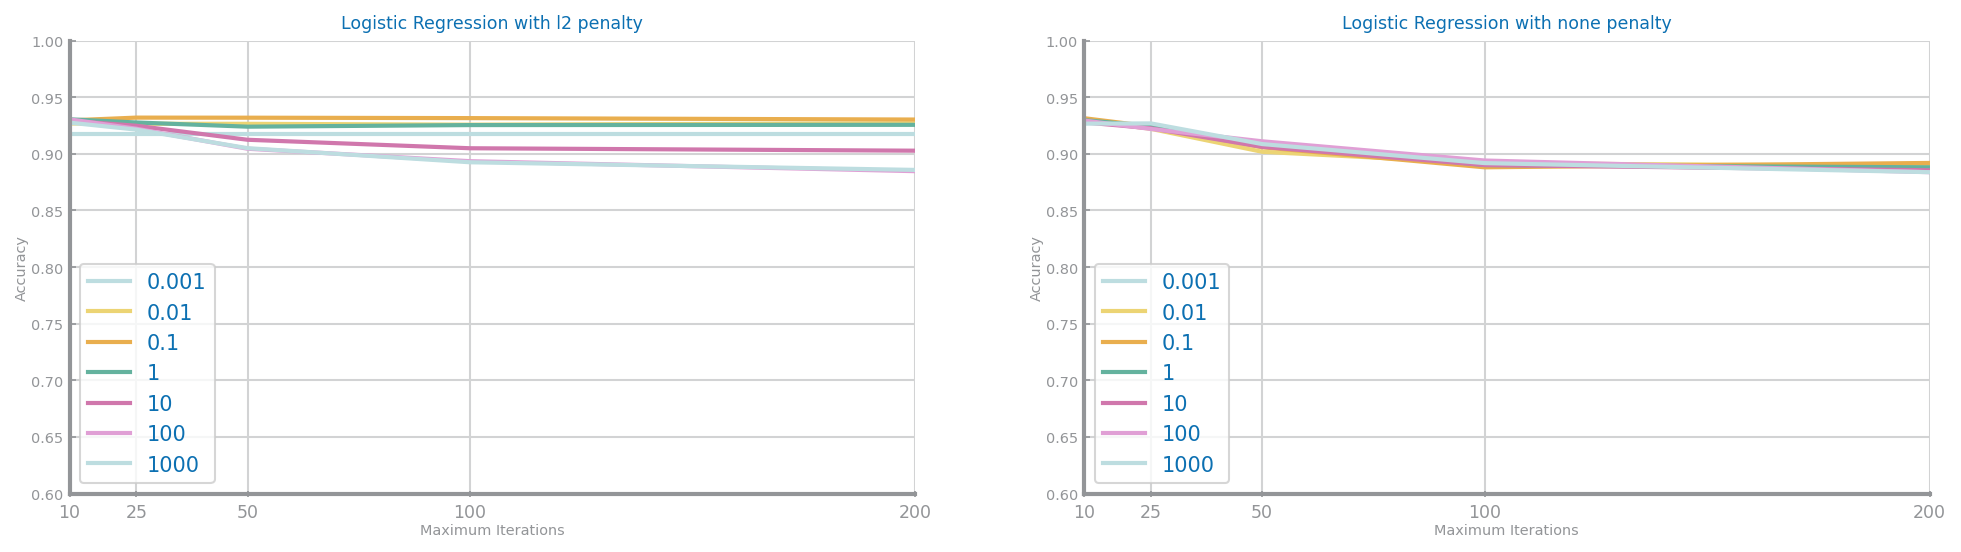

In [6]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y, n_holdouts=5)

	Model Statistics
    Accuracy  1.00  0.88
      Recall  0.99  0.46
 Specificity  1.00  0.92
   Precision  0.99  0.35


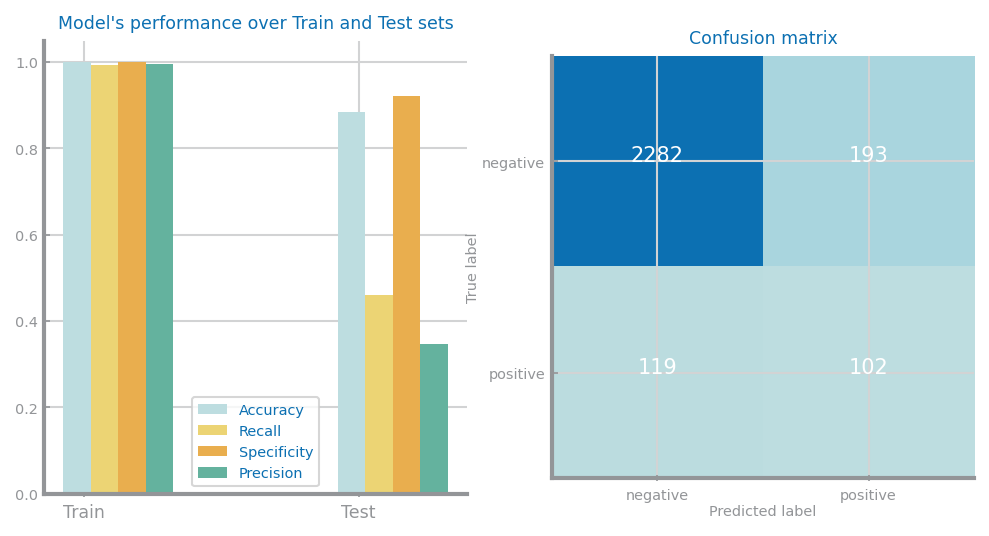

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)

<br/>
<br/>
<br/>
<br/>
<br/>

## Reduced 32

In [8]:
data: pd.DataFrame = pd.read_csv('../../datasets/oral_reduced/ORAL_reduced32.csv', sep=';', header=None)
y: np.ndarray = data.iloc[:,-1:].values
y: np.ndarray = np.array([x[0] for x in y])
X: np.ndarray = data.iloc[:,:-1]
labels = pd.unique(y)

<Figure size 600x450 with 0 Axes>

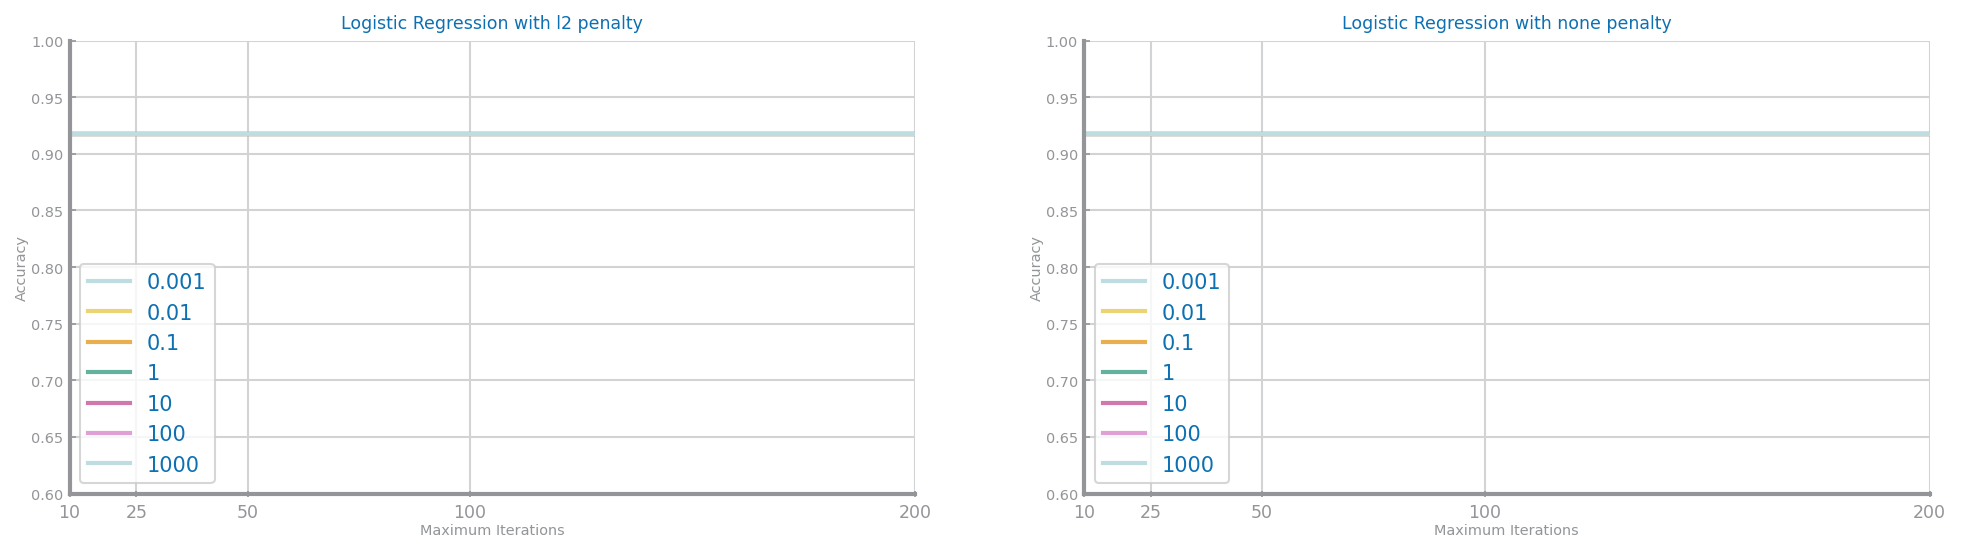

In [9]:
model, evaluation, cnf_mtx = log_reg_analysis(X, y, n_holdouts=5)

	Model Statistics
    Accuracy  0.92  0.92
      Recall  0.00  0.00
 Specificity  1.00  1.00
   Precision  nan  nan


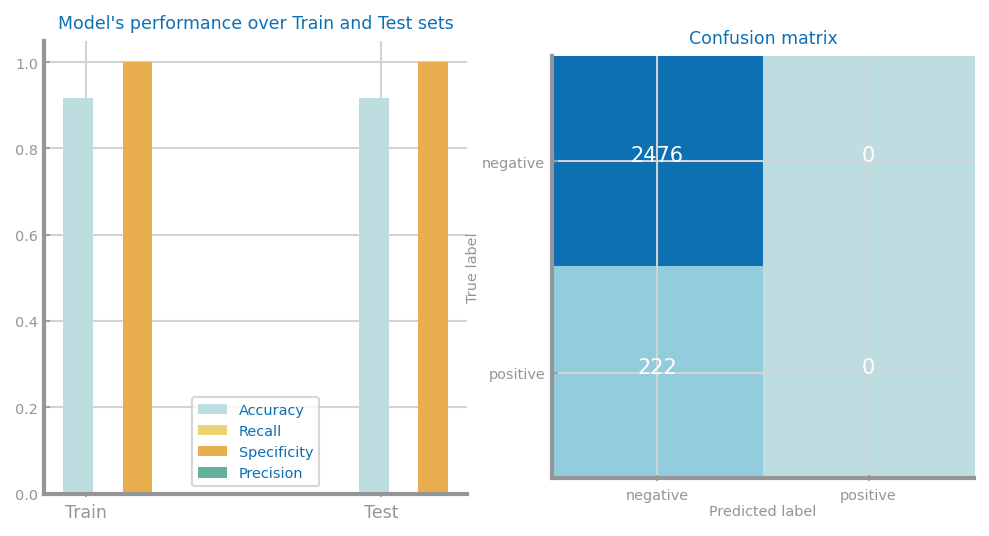

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

pretty_metrics(evaluation)